In [17]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Gaps across the years

In a previous kernel I estimated the SHSAT applicants gap that happened in 2017. It measures the amount of applicants that took the SHSAT less than what we expected. In this kernel, I will try to understand how this gap evolves across the years and, try to answer one question:

"Is the estimated gap for 2017 still relevant when we talk about 2018?"

In the way to find the answer, I will take the following steps:

- Calculate the gap of applicants that happened from 2013 to 2016 in Central Harlem (a district of NYC)
- Compare the gaps that happened in each year to the gaps of the subsequent years
- Visualize the results
- Infer what this relation mean to our most recent data


# Data used

The data used in this kernel is quite different from the last one. Basically, we are targeting schools from Central Harlem, this region in New York:

![](../data/keep/map-harlem.png)

Characteristics from the data:

- Made as a mix between the handed-out D5 dataset and a dataset available in the [NYC InfoHub][1]
- Comprehends 24 schools from Central Harlem (18 after dropping those with missing values)
- From 2013 to 2016
- NYS test results for 7th graders
- SHSAT statistics for 8th graders

In [18]:
# load dataframe
df = pd.read_pickle('../data/process/d5_full.pkl')
df = df[df.notnull().all(axis=1)]
nschools = df.reset_index()['DBN'].nunique()
print("loaded {} schools".format(nschools))

# load model
with open('../data/output/full_model.pkl', mode='rb') as f:
    model = pickle.load(f)
print("loaded model")

df.head()

loaded 21 schools
loaded model


School Name  Percent Asian  Percent Black  \
DBN    Year                                                           
05M046 2015    P.S. 046 Arthur Tappan          0.009          0.506   
       2016    P.S. 046 Arthur Tappan          0.007          0.499   
05M123 2015  P.S. 123 Mahalia Jackson          0.013          0.546   
       2016  P.S. 123 Mahalia Jackson          0.015          0.517   
05M129 2015   P.S. 129 John H. Finley          0.018          0.418   

             Percent Hispanic  Percent White  Percent Other  \
DBN    Year                                                   
05M046 2015             0.465          0.010          0.010   
       2016             0.475          0.010          0.009   
05M123 2015             0.392          0.032          0.017   
       2016             0.412          0.040          0.016   
05M129 2015             0.511          0.022          0.031   

             Percent English Language Learners  \
DBN    Year                                      
05M046 2015                              0.108   
       2016                              0.091   
05M123 2015                              0.188   
       2016                              0.185   
05M129 2015                              0.126   

             Percent Students with Disabilities  \
DBN    Year                                       
05M046 2015                               0.261   
       2016                               0.280   
05M123 2015                               0.262   
       2016                               0.260   
05M129 2015                               0.215   

             Percent of Students Chronically Absent  Economic Need Index  \
DBN    Year                                                                
05M046 2015                                   0.394                0.903   
       2016                                   0.409                0.909   
05M123 2015                                   0.494                0.835   
       2016                                   0.362                0.868   
05M129 2015                                   0.329                0.854   

             Charter School?  Number Tested - ELA  Mean Scale Score - ELA  \
DBN    Year                                                                 
05M046 2015              0.0                 66.0               -1.380656   
       2016              0.0                 58.0               -1.103425   
05M123 2015              0.0                 48.0               -1.999821   
       2016              0.0                 53.0               -0.909242   
05M129 2015              0.0                 53.0               -1.005304   

             # Level 1 - ELA  % Level 1 - ELA  # Level 2 - ELA  \
DBN    Year                                                      
05M046 2015             41.0         62.12121             16.0   
       2016             39.0         67.24138             14.0   
05M123 2015             36.0         75.00000             10.0   
       2016             24.0         45.28302             22.0   
05M129 2015             32.0         60.37736             15.0   

             % Level 2 - ELA  # Level 3 - ELA  % Level 3 - ELA  \
DBN    Year                                                      
05M046 2015         0.242424              9.0         0.136364   
       2016         0.241379              2.0         0.034483   
05M123 2015         0.208333              2.0         0.041667   
       2016         0.415094              7.0         0.132075   
05M129 2015         0.283019              5.0         0.094340   

             # Level 4 - ELA  % Level 4 - ELA  # Level 3+4 - ELA  \
DBN    Year                                                        
05M046 2015              0.0         0.000000                9.0   
       2016              3.0         0.051724                5.0   
05M123 2015              0.0         0.000000                2.0   
       2016              0.0         0

In [21]:
df.reset_index().DBN.nunique()

21

# Calculate the gap of applicants

## Model

First we transform the inputs, then we fit them to the target logit values.

In [4]:
def get_inputs(df):
    base_df = df[[  # explanatory variables
        'Charter School?',
        'Percent Asian',
        'Percent Black',
        'Percent Hispanic',
        'Percent Other',
        'Percent English Language Learners',
        'Percent Students with Disabilities',
        'Economic Need Index',
        'Percent of Students Chronically Absent',
        
        'Mean Scale Score - ELA',
        '% Level 2 - ELA',
        '% Level 3 - ELA',
        '% Level 4 - ELA',
        'Mean Scale Score - Math',
        '% Level 2 - Math',
        '% Level 3 - Math',
        '% Level 4 - Math',
    ]]

    # transform the variables (apply the PCA)
    n_components = 8
    pca = PCA(n_components)
    transformed = pca.fit_transform(base_df)
    transformed = pd.DataFrame(transformed, index=base_df.index, columns=["PC{}".format(i+1) for i in range(n_components)])

    # add a constant column (needed for our model with statsmodels)
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)

    return inputs


def get_outputs(df):
    outputs = logit(df['% SHSAT Testers'])
    return outputs

inputs = get_inputs(df)
outputs = get_outputs(df)

In [5]:
# model

results = model.fit()  # full model
predictions = model.predict(results.params, exog=inputs)
predictions = pd.Series(predictions, index=df.index, name='% SHSAT Testers')

In [6]:
# model2

years = df.reset_index()['Year']
years.index = df.index

inputs2 = pd.DataFrame(index=df.index)
inputs2['constant'] = 1.0
inputs2['year_2015'] = (years == 2015).astype(int)
inputs2['prediction'] = predictions

model2 = sm.RLM(outputs, inputs2)
results2 = model2.fit()
predictions2 = results2.fittedvalues

In [7]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                   40
Model:                            RLM   Df Residuals:                       37
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 07 Aug 2018                                         
Time:                        16:53:06                                         
No. Iterations:                    13                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -1.3162      0.163     -8.062      0.000      -1.636      -0.996
year_2015      0.1866      0.197      0.948      0.343      -0.199       0.572
prediction     0.4282      0.109      3.933      0.000       0.215       0.642
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

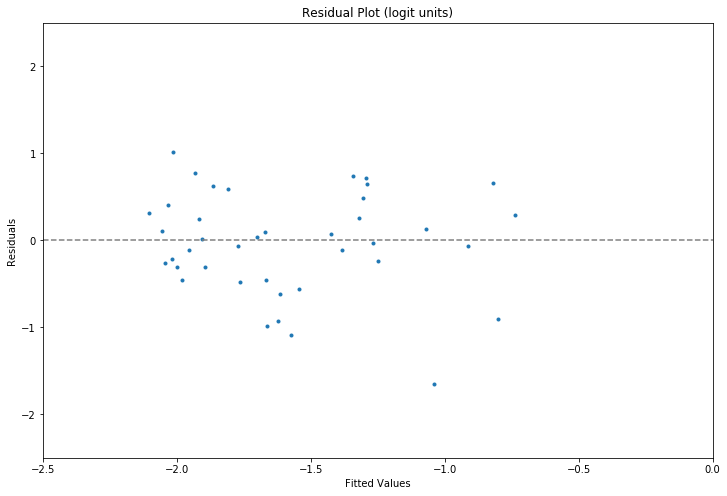

In [8]:
_predictions = predictions2
_actual = outputs

xs = _predictions
ys = _actual - _predictions  # residual

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, '.')
plt.axhline(0.0, linestyle='--', color='gray')
plt.xlim(-2.5, 0)
plt.ylim(-2.5, 2.5)
plt.title("Residual Plot (logit units)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals");

In [9]:
mae = median_absolute_error(_actual, _predictions)
mse = mean_squared_error(_actual, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.35977207805200273
Mean Squared Error: 0.33402285295366857


# Compare gaps across the years

Well... We need a way to compare gaps from one year to the other. To do so, I will assume the gap in each school follows a certain formula:

$G_y = w \cdot G_{y-1} + (1 - w) \cdot B + \epsilon$

Where:

- $G_y$ is the gap in the year y
- $B$ is the baseline gap of the school
- $w$ is a weight used to balance the  past year gap and the baseline gap
- $\epsilon$ is an error term and denotes noise from students of one year to the other

Ideally, we would want to know B. B can indicate a range of factors related to a certain school, like not having enough incentive for SHSAT, a trend of underconfidence among students, good exposure of SHSAT, etc.

Sadly, we can't, know the exact value of B. So we use an estimate for it. This estimate is the mean of the 

And I'd argue that the best estimate we have for it is the actual gap that happened in 2017 (that is, when we consider the big dataset). So we simplify the formula above to:

$G_y = G_{y-1} + \epsilon$

And this is what we are gonna base ourselves upon.

Now I will make some visualizations comparing the estimated gaps for each school along the years. Below the graphs there is an explanation.

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


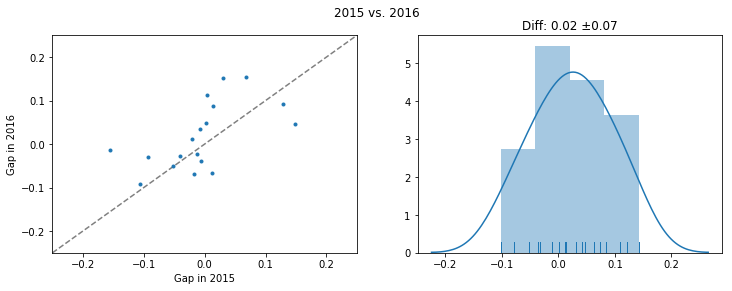

In [12]:
pct_residuals = expit(_actual) - expit(_predictions)
pct_residuals = pct_residuals.drop('84M341')  # drop outlier
pivoted = pct_residuals.reset_index().pivot(index='DBN', columns='Year', values=0)


# visualize
y1 = 2015
y2 = 2016

diffs = (pivoted[y2] - pivoted[y1]).dropna()
mean = diffs.mean()
std = diffs.std()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
fig.suptitle("%s vs. %s" % (y1, y2))

ax1.plot([-0.25, 0.25], [-0.25, 0.25], '--', color='gray')
ax1.plot(pivoted[y1], pivoted[y2], '.')
ax1.set_xlabel("Gap in %s" % y1)
ax1.set_ylabel("Gap in %s" % y2)
ax1.set_xlim(-0.25, 0.25)
ax1.set_ylim(-0.25, 0.25)

sns.distplot(diffs, ax=ax2, rug=True)
ax2.set_title("Diff: {:.2f} ±{:.2f}".format(mean, std));

In [13]:
pivoted.corr(method='pearson')

Year,2015,2016
Year,,
2015,1.000000,0.584673
2016,0.584673,1.000000


In [14]:
pivoted.corr(method='spearman')

Year,2015,2016
Year,,
2015,1.000000,0.673891
2016,0.673891,1.000000


This is a lot of uncertainty.

However, the gap can still be used for good. We just have this information that a big part of what it measures is noise.

**Left**:

The left plots compare the percentual gaps of each school from 2015 to 2016r. If one year was totally equal to one another, the points would be right on top of the dashed line.


**Right**:

The right plots represent the distribution of errors. The plot titles gives the mean plus standard deviation of the distribution. This is a good way of  

As you can see,

While the left plots compares one variable to the other, the right plots present the distribution of errors.

As you can see, the distribution of errors follows almost a normal distribution, centered at zero and with standard deviation around 0.07. This is a good indicator, as we can say that, if the gap in a school is 22% one year, the next year this gap will be sopmething around 22% +- 8%.

And this means that the gap in one year is indeed somewhat close to the gap in the past year. And the expected gap for the next year is just the gap of the current year. Of course, if we had more data from other years, we could better be able to create a time series model, but, as only data from 2017 is available for all schools, this simple model will suffice.

One thing I would like to note is that school way under the diagonal line in the lower-left corner. This corresponds to a given school:

In [ ]:
# show school here

We can see that there was some weird shift between the number of applicants in 2015 and 2016 and the model not predicting the gap is exactly what we would expect.

# Limitations of this approach

We used limited data and in a way that is different from the actual 2017 model. Given that this comprehend a much smaller geographic region than the whole city of New York, we can expect that the variance of the error when comprehending all schools may be higher than what was found here.

And, what does this error mean? In this model it is just the amount of the gap in one year that cannot be predicted by the previous. We can say, some noise in the student populations, combined of what would be expected of each school.

# Does this effect the relevance of the "Predicting the applicants gap" kernel

Well, in a certain way, it adds more uncertainty in the model. Or more acuratelly, it measures uncertainty that was already present there. The important thing to note though, is that, while we have an uncertainty in predicting the gap for next year, this uncertainty is inherent to the system, and having a model that can work, despite this uncertainty, is better than having none.

I personally believe the gap can be better estimated as a composite of a given baseline for each school and what happened in the previous years. This baseline would measure certain aspects that cannot be captured in our models, like, how much informed the school is about SHSAT, the confidence of students in it, etc... But, it can't be measured directly and the best estimate we have of it is actually the gap we estimated in 2017.

**example of what school would you choose**

So, that's it.